In [1]:
import os
import glob
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

import cv2
from google.colab import drive
import zipfile

# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from sklearn.cluster import KMeans


from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from skimage import metrics


# libraries installed to convert pdfs to images
!apt-get install poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import PDFInfoNotInstalledError, PDFPageCountError, PDFSyntaxError




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (301 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...


In [79]:
# convert the pdfs to images if pdf inputs
def pdf_to_image(path=''):
    # read the pdfs from dir files and save under images dir

    # Directory to save images
    if path.endswith("/pdfs"):
      pdf_path = path+'/'
      im_path = path.replace("/pdfs", "")
    else:
      im_path = path

    images_dir = im_path+"/images/"

    # Create the images directory if it doesn't exist
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)

    # Get all PDF files from directory
    pdf_files = [pdf_path + filename for filename in os.listdir(path) if filename.endswith('.pdf')]
    # print('pdf_files', pdf_files)
    for pdf_file in pdf_files:
        try:
            images = convert_from_path(pdf_file)
            # print(f"Processing {pdf_file}")

            for i, image in enumerate(images):
                # Create filename for the image
                fname = os.path.join(images_dir, os.path.basename(pdf_file).replace('.pdf', f'_image{i}.jpg'))
                # Save the image

                image.save(fname, "JPEG")
                # print(f"Saved {fname}")

        except (PDFInfoNotInstalledError, PDFPageCountError, PDFSyntaxError) as e:
            print(f"Error processing {pdf_file}: {e}")

    return images_dir[:-1] # path of all the images

In [80]:
def extractor(zip_ref, dest_path):
    os.makedirs(dest_path, exist_ok=True)
    zip_ref.extractall(dest_path)
    # zip_ref.close()
    return None


def handle_duplicates(file_path):
    base, extension = os.path.splitext(file_path)
    counter = 1
    new_file_path = f"{base}_{counter}{extension}"
    while os.path.exists(new_file_path):
        counter += 1
        new_file_path = f"{base}_{counter}{extension}"
    return new_file_path



def unzipper(path, dest_path=None):
    """Args:
        path: the source zip file path
        dest_path: the destination path to extract the zip file
        -- returns path of the images directory, creates a directory in the destination path if provided
        else it creates a folder in the current directory
        the directory would be created under the name of images for image files and pdfs for pdf files
    """

    images_path = None

    # Open the zip file
    with zipfile.ZipFile(path, 'r') as zip_ref:
        # List all the contents of the zip file
        contents = zip_ref.infolist()



        if dest_path is None:
            dest_path = os.getcwd()

        images_dest_path = os.path.join(dest_path, 'images')
        pdfs_dest_path = os.path.join(dest_path, 'pdfs')


        # Extract all the contents of the zip file
        filename = contents[0].filename
        if filename.endswith('.pdf'):
            extractor(zip_ref, pdfs_dest_path)
            # Convert PDFs to images
            pdf_to_image(pdfs_dest_path)


        elif filename.endswith(('.jpg', '.jpeg', '.png')):
            extractor(zip_ref, images_dest_path)

        else:
            print(f"Unsupported file type: {filename}")


    zip_ref.close()
    return images_dest_path



In [81]:

# lists the number of images in the folder --> optional helper funtion
def no_of_item(path):
    all_items = os.listdir(path)
    num_files = len([item for item in all_items if os.path.isfile(os.path.join(path, item))])
    return num_files

In [91]:
# resize all of the images  in the directory
# simple code to resize all of the images, optimize it, add in check points and clean up the checkpoints after completion

# List image files

def img_resizer(source_path):
    all_images = []
    all_names = []

    for img_name in os.listdir(source_path):
        img_path = os.path.join(source_path, img_name)
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img = Image.open(img_path).convert('RGB')
            img = np.array(img)
            image = cv2.resize(img, (299, 399))  # resize
            all_images.append(image)
            all_names.append(img_name)

    return all_images, all_names

In [92]:
# os.path.basename('/content/drive/MyDrive/3223674_Objection-to-Bill_EOB-Zero_06032024063126_MAILING_2024_06_03_13_30_03_1717403403-49Cm1001717403403_8_opt_0_image6.jpg')

In [93]:
# main function
# takes input of target iamge, threshold and the zip_file path to chose the images from the zip file
def incept(img_path, thres, zip_path):



    # Load the new image
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")


    # Convert the PIL image to a numpy array
    new_img = np.array(pil_img)

    # Ensure the image is in uint8 format
    if new_img.dtype != np.uint8:
        new_img = new_img.astype(np.uint8)

    # Resize the new image to a fixed size to ensure consistency
    try:
        new_img_resized = cv2.resize(new_img, (299, 399))
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")


    #unzip the zipped file, returns images directory path
    z_images_path = unzipper(zip_path, zip_path.replace('/'+os.path.basename(zip_path), ''))  #unzipper(zip_path) # optional argument for destination path

    # 'all_images' contains the resized images dataset
    all_images, all_names = img_resizer(z_images_path) # takes input the path of images folder
    # all_images_resized = [cv2.resize(img, (224, 224)) for img in all_images]

    # Convert images to numpy arrays
    new_image_np = np.array(new_img_resized)
    all_images_np = np.array(all_images)

    # Preprocess images for InceptionV3
    new_image_inception = inception_preprocess_input(new_image_np)
    all_images_inception = inception_preprocess_input(all_images_np)

    # Load pre-trained InceptionV3 model
    inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='max')

    # Extract InceptionV3 features
    new_features_inception = inception_model.predict(np.expand_dims(new_image_inception, axis=0))
    all_features_inception = inception_model.predict(all_images_inception)

    # Compute structural similarity between the new image and images in your dataset using InceptionV3 features
    inception_ssim_scores = [metrics.structural_similarity(new_features_inception.flatten(), features_inception.flatten())
                            for features_inception in all_features_inception]
    # try with cosine similarity and dbscan similarity

    # Set the threshold for similarity score
    threshold = thres

    # Find top similar images above the threshold using InceptionV3 features
    inception_top_indices = [i for i, score in enumerate(inception_ssim_scores) if score >= threshold]


    if len(inception_top_indices) > 0:

      # Define a list to store image names and images
      clustered_img = []

        # Now clustered_img contains tuples of (image_name, image) for each index in inception_top_indices

        # Plot the similar images using InceptionV3 features
      plt.figure(figsize=(10, 10))
      # plt.suptitle("Similar Images using InceptionV3 Features", fontsize=16)
      # print("inception_top_indices", inception_top_indices)
      for i, index in enumerate(inception_top_indices):
            # plt.figure(figsize=(10, 10))
            plt.imshow(all_images[index])
            image_name = all_names[index]
            # image = cv2.cvtColor(all_images[index], cv2.COLOR_RGB2BGR)
            img = cv2.imread(os.path.join(z_images_path, image_name))  # Read the image
            if img is not None:
                clustered_img.append((image_name, img)) # clustered_img contains tuples of (image_name, image) for each index in inception_top_indices
            else:
                  print(f"Failed to read image {image_name} at index {index}")
            plt.title(f'Index: {index}, SSIM: {inception_ssim_scores[index]:.2f}, Name: {all_names[index]} ')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

      return inception_top_indices, all_images, inception_ssim_scores, clustered_img

    else:
      return inception_top_indices, all_images, inception_ssim_scores, "no similar images"
    # add the function to return the similar images


1/1 [==============================] - 7s 7s/step


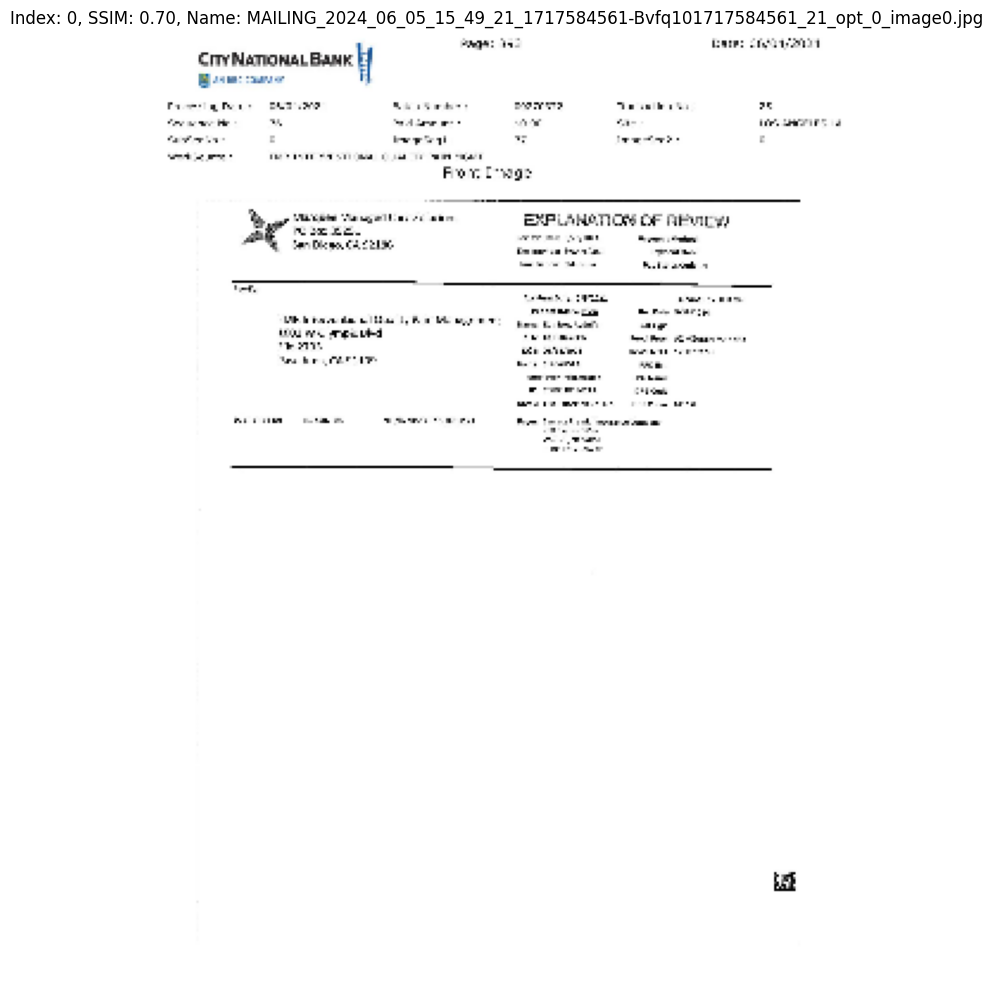

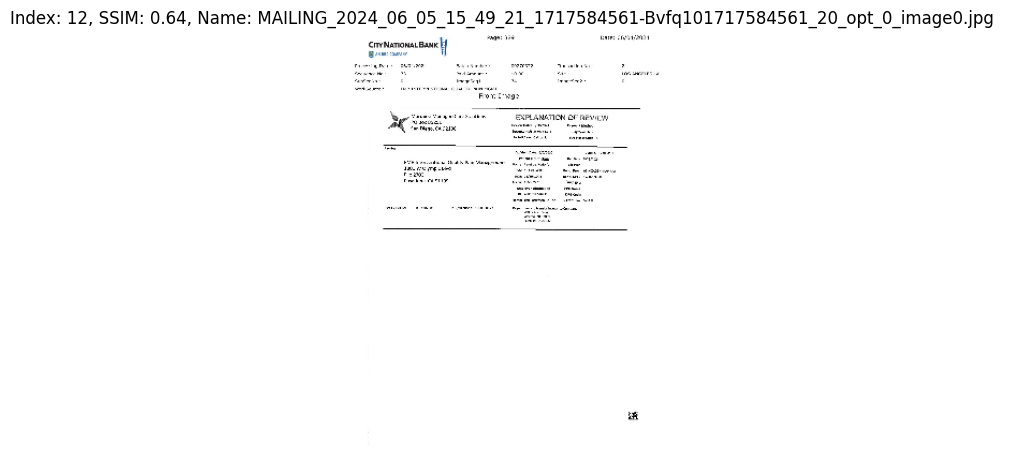

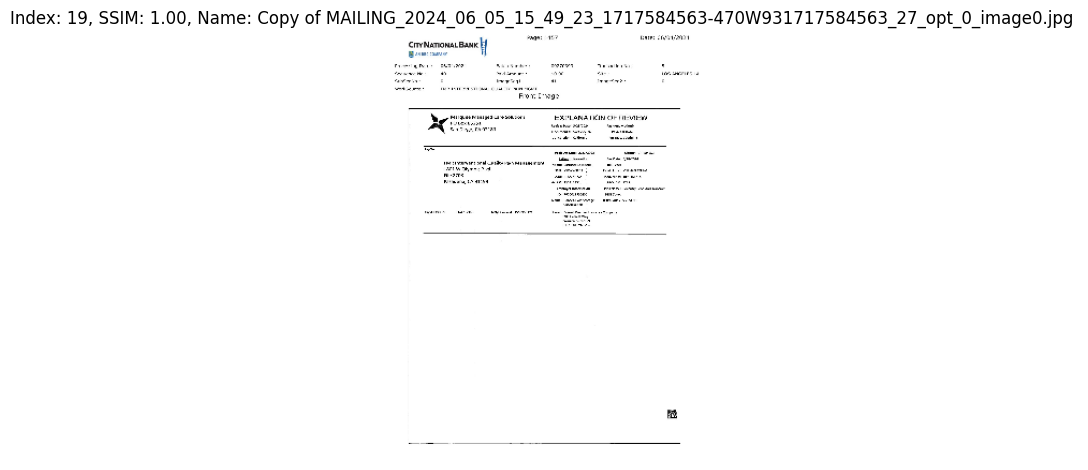

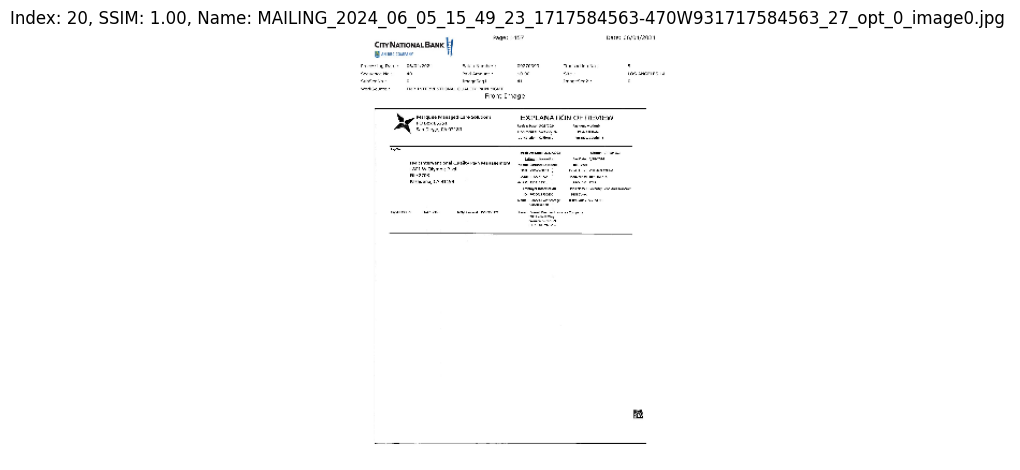

In [97]:
# call the main function :
top_indexes, imgs, ssim, cluster = incept('/content/drive/MyDrive/eob_small/aaaaaaaaaaa.jpg', 0.60, '/content/drive/MyDrive/eob_small/eobs.zip')
# unzipper("/content/drive/MyDrive/eob_small/eobs.zip", "/content/drive/MyDrive/eob_small")

In [98]:
top_indexes

[0, 12, 19, 20]